# Facial Expression Recognition with PyTorch

*Author: Eda AYDIN*

# Business Understanding

Facial Expression Recognition is a critical technology that is gaining traction in various industries, including healthcare, entertainment, and security. The goal of this project is to develop an accurate and efficient Facial Expression Recognition model using the PyTorch framework. The model will be trained on a large dataset of facial expressions to recognize different emotions, including happiness, sadness, fear, anger, and surprise. The ultimate objective of this project is to provide businesses with a tool that can improve customer experience, increase security, and enhance overall operational efficiency. For instance, the technology can be used in healthcare to detect early signs of depression or anxiety in patients, in entertainment to enhance gaming experiences, and in security to monitor public spaces for suspicious behavior. The Facial Expression Recognition with PyTorch project has the potential to revolutionize various industries by providing an automated, accurate, and reliable tool for recognizing emotions.

# Data Understanding

The Face Expression Recognition dataset available on Kaggle contains 28,709 images of human faces, labeled with seven different facial expressions, including angry, disgust, fear, happy, sad, surprise, and neutral. 

The dataset is split into two subsets, a training set of 24,706 images and a test set of 4,003 images. The images are grayscale, 48×48 pixels in size, and the data is stored in CSV format. Each row of the CSV file corresponds to an image and contains the pixel values of the image, the emotion label, and other attributes, such as the image usage and intensity. 

The dataset is well-balanced, with each emotion class containing approximately the same number of images. It is important to note that the images were extracted from the FER2013 dataset and preprocessed to contain only faces with frontal pose and appropriate brightness, resulting in some loss of information. 

Additionally, the dataset contains some images with low resolution or artifacts, which may affect the performance of the model. 

Overall, the Face Expression Recognition dataset provides a diverse and labeled set of images for training and testing facial expression recognition models.

# Install libraries, packages and dataset

In [1]:
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-e96bzodn
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-e96bzodn
  Resolved https://github.com/albumentations-team/albumentations to commit b773a1aa69f9c823c7f593205614d05d32c039cb
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 MB 17.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.5.4.60
    Uninstalling opencv-contrib-python-4.5.4.60:
      Successfully uninstalled opencv-contrib-python-4.5.4.60


# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Configurations

In [3]:
TRAIN_IMG_FOLDER_PATH = "/kaggle/input/face-expression-recognition-dataset/images/train"
VALID_IMG_FOLDER_PATH = "/kaggle/input/face-expression-recognition-dataset/images/validation"

LR = 0.001
BATCH_SIZE = 32
EPOCHS = 15

DEVICE = 'cuda'
MODEL_NAME = 'efficientnet_b0'

# Load Dataset

In [4]:
from torchvision.datasets import ImageFolder
from torchvision import transforms as T
import random

In [5]:
train_augs = T.Compose([
    T.RandomHorizontalFlip(p = 0.5),
    T.RandomRotation(degrees=(-20, + 20)),
    T.ToTensor() # Convert a PIL image or numpy.ndarray to tensor (h, w, c) --> (c, h, w)
])

valid_augs = T.Compose([
    T.ToTensor()
])

In [6]:
trainset = ImageFolder(TRAIN_IMG_FOLDER_PATH, transform = train_augs)
validset = ImageFolder(VALID_IMG_FOLDER_PATH, transform = valid_augs)

In [7]:
print(f"Total no. of examples in trainset : {len(trainset)}")
print(f"Total no. of examples in validset : {len(validset)}")

Total no. of examples in trainset : 28821
Total no. of examples in validset : 7066


In [8]:
print(trainset.class_to_idx)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


Text(0.5, 1.0, 'happy')

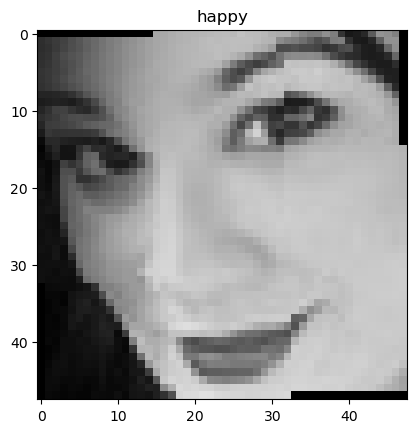

In [9]:
class_names = trainset.classes

index = random.randint(0, len(trainset)-1)
image, label = trainset[index]

plt.imshow(image.permute(1, 2, 0)) # (h, w, c)
plt.title(class_names[label])

Text(0.5, 1.0, 'angry')

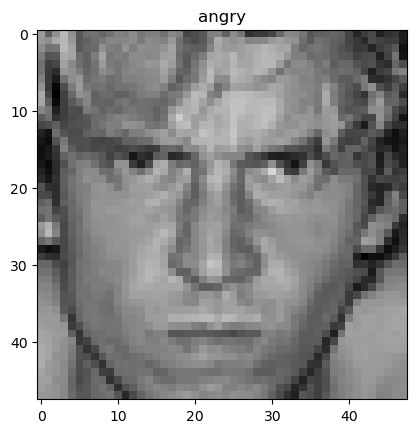

In [10]:
class_names = validset.classes

index = random.randint(0, len(validset)-1)
image, label = validset[index]

plt.imshow(image.permute(1, 2, 0)) # (h, w, c)
plt.title(class_names[label])

# Load Dataset into Batches

In [11]:
from torch.utils.data import DataLoader

In [12]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [13]:
print(f"Total no. of batches in trainloader : {len(trainloader)}")
print(f"Total no. of batches in validloader : {len(validloader)}")

Total no. of batches in trainloader : 901
Total no. of batches in validloader : 221


In [14]:
for images, labels in trainloader:
    break;

print(f"One image batch shape : {images.shape}")
print(f"One label batch shape : {labels.shape}")

One image batch shape : torch.Size([32, 3, 48, 48])
One label batch shape : torch.Size([32])


# Create Model 

In [15]:
import timm
from torch import nn

In [39]:
class FaceModel(nn.Module):
    
    def __init__(self):
        super(FaceModel, self).__init__()
        
        self.net = timm.create_model(MODEL_NAME,
                                        pretrained = True,
                                        num_classes = 7)
        
    def forward(self, images, labels = None):
        logits = self.net(images)
        
        if labels != None:
            loss = nn.CrossEntropyLoss()(logits, labels)
            return logits, loss
        
        return logits

In [40]:
model = FaceModel()
model = model.to(DEVICE)
from torchinfo import summary
summary(model.net)

Layer (type:depth-idx)                        Param #
EfficientNet                                  --
├─Conv2d: 1-1                                 864
├─BatchNormAct2d: 1-2                         64
│    └─Identity: 2-1                          --
│    └─SiLU: 2-2                              --
├─Sequential: 1-3                             --
│    └─Sequential: 2-3                        --
│    │    └─DepthwiseSeparableConv: 3-1       1,448
│    └─Sequential: 2-4                        --
│    │    └─InvertedResidual: 3-2             6,004
│    │    └─InvertedResidual: 3-3             10,710
│    └─Sequential: 2-5                        --
│    │    └─InvertedResidual: 3-4             15,350
│    │    └─InvertedResidual: 3-5             31,290
│    └─Sequential: 2-6                        --
│    │    └─InvertedResidual: 3-6             37,130
│    │    └─InvertedResidual: 3-7             102,900
│    │    └─InvertedResidual: 3-8             102,900
│    └─Sequential: 2-7         

# Create Train and Eval Function

In [18]:
from tqdm import tqdm

In [19]:
def multiclass_accuracy(y_pred, y_true):
    top_p, top_class = y_pred.topk(1, dim = 1)
    equals = top_class = y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [20]:
def train_fn(model, dataloader, optimizer, current_epo):
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    tk = tqdm(dataloader, desc = "EPOCH" + "[TRAIN]" + str(current_epo + 1) + "/" + str(EPOCHS))
    
    for t, data in enumerate(tk):
        images, labels = data
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        logits, loss = model(images, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_acc += multiclass_accuracy(logits, labels)
        tk.set_postfix({'loss' : '%6f' %float(total_loss / (t+1)), 'acc' : '%6f' %float(total_acc / (t+1)),})
        
    return total_loss / len(dataloader), total_acc / len(dataloader)
        

In [21]:
def eval_fn(model, dataloader, current_epo):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    tk = tqdm(dataloader, desc = "EPOCH" + "[TRAIN]" + str(current_epo + 1) + "/" + str(EPOCHS))
    
    for t, data in enumerate(tk):
        images, labels = data
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        logits, loss = model(images, labels)
        
        total_loss += loss.item()
        total_acc += multiclass_accuracy(logits, labels)
        tk.set_postfix({'loss' : '%6f' %float(total_loss / (t+1)), 'acc' : '%6f' %float(total_acc / (t+1)),})
        
    return total_loss / len(dataloader), total_acc / len(dataloader)
        

# Create Training Loop

In [22]:
optimizer = torch.optim.Adam(params = model.parameters(),
                             lr = LR)

In [23]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
    train_loss, train_acc = train_fn(model, trainloader, optimizer, i)
    valid_loss, valid_acc = eval_fn(model, validloader, i)
    
    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best-weights.pt')
        print("SAVED-BEST-WEIGHTS")
        best_valid_loss = valid_loss

EPOCH[TRAIN]1/15: 100%|██████████| 221/221 [00:36<00:00,  6.02it/s, loss=1.347512, acc=3.252121]


SAVED-BEST-WEIGHTS


EPOCH[TRAIN]2/15: 100%|██████████| 221/221 [00:10<00:00, 21.60it/s, loss=1.197729, acc=3.252121]


SAVED-BEST-WEIGHTS


EPOCH[TRAIN]3/15: 100%|██████████| 221/221 [00:10<00:00, 21.71it/s, loss=1.130488, acc=3.252121]


SAVED-BEST-WEIGHTS


EPOCH[TRAIN]4/15: 100%|██████████| 221/221 [00:09<00:00, 23.03it/s, loss=1.082013, acc=3.252121]


SAVED-BEST-WEIGHTS


EPOCH[TRAIN]5/15: 100%|██████████| 221/221 [00:09<00:00, 22.25it/s, loss=1.066187, acc=3.252121]


SAVED-BEST-WEIGHTS


EPOCH[TRAIN]6/15: 100%|██████████| 221/221 [00:10<00:00, 22.09it/s, loss=1.057858, acc=3.252121]


SAVED-BEST-WEIGHTS


EPOCH[TRAIN]7/15: 100%|██████████| 221/221 [00:10<00:00, 21.92it/s, loss=1.048754, acc=3.252121]


SAVED-BEST-WEIGHTS


EPOCH[TRAIN]9/15: 100%|██████████| 221/221 [00:10<00:00, 21.34it/s, loss=1.018522, acc=3.252121]


SAVED-BEST-WEIGHTS


EPOCH[TRAIN]10/15: 100%|██████████| 221/221 [00:09<00:00, 22.11it/s, loss=0.979192, acc=3.252121]


SAVED-BEST-WEIGHTS


EPOCH[TRAIN]15/15: 100%|██████████| 221/221 [00:10<00:00, 21.73it/s, loss=1.011183, acc=3.252121]


# Inference

In [24]:
def view_classify(img, ps):
  
    classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'suprise']
    
    ps = ps.data.cpu().numpy().squeeze()
    img = img.numpy().transpose(1,2,0)
    
    fig, (ax1, ax2) = plt.subplots(figsize = (5,9), ncols = 2)
    ax1.imshow(img)
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    
    plt.tight_layout()
    
    return None

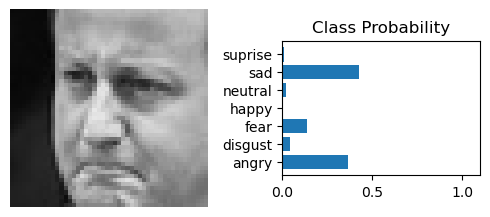

In [34]:
image, label = validset[83]
image = image.unsqueeze(0)

model.load_state_dict(torch.load('best-weights.pt'))

logits = model(image.to(DEVICE))
probs = nn.Softmax(dim=1)(logits)

view_classify(image.squeeze(), probs)

In [29]:
!pip freeze > requirements.txt

In [37]:
!cat requirements.txt

absl-py==1.4.0
accelerate==0.12.0
access==1.1.8
affine==2.4.0
aiobotocore==2.4.2
aiohttp @ file:///home/conda/feedstock_root/build_artifacts/aiohttp_1663850771047/work
aiohttp-cors==0.7.0
aioitertools==0.11.0
aiorwlock==1.3.0
aiosignal @ file:///home/conda/feedstock_root/build_artifacts/aiosignal_1667935791922/work
albumentations==1.3.0
alembic==1.9.4
altair==4.2.2
annoy==1.17.1
ansiwrap==0.8.4
anyio @ file:///home/conda/feedstock_root/build_artifacts/anyio_1666191106763/work/dist
apache-beam==2.44.0
aplus==0.11.0
appdirs==1.4.4
argon2-cffi @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi_1640817743617/work
argon2-cffi-bindings @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi-bindings_1649500320262/work
arrow==1.2.3
arviz==0.12.1
astroid==2.14.2
astropy==4.3.1
astunparse==1.6.3
async-timeout @ file:///home/conda/feedstock_root/build_artifacts/async-timeout_1640026696943/work
asynctest==0.13.0
atpublic==2.3
attrs @ file:///home/conda/feedstock_root/build_ar